This Notebook contains our solution to the Kaggle SF Crime problem
https://www.kaggle.com/c/sf-crime

We started with a basic exploration of the data.
- Count unique values for each variable
- View most common values
- XY plot of lat/long w. circles to indicate number of crimes
- Time series plots to see how category use changes over time

Interesting Points:
- Most crime on Friday, then Wednesday. Least on Sunday.
- X and Y latitude have same number of distinct values. Seem to be somehow linked to locations
  since, despite there being a lots of sig fig, they still can be frequency counted
- 800 Block of BRYANT ST has 4x+ more data points than anyplace else. Seems to link w/ most freq X and Y
- "Other Offenses" are common
- The dates with the most crime are new years day. Also the first of months.
- Note: Strange max value of Y = 90 for 67 values. These appear to be in Chicago, but the data has addresses in SF. We removed this data from our analysis.


In [2]:
#This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries.
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import csv
import datetime

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.grid_search import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.decomposition import PCA

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import log_loss

In [19]:
data_orig = pd.read_csv("train.csv")
test_orig = pd.read_csv("test.csv")

# Count distinct for each variable:
print "There are a total of {:,}, values.".format(len(data_orig))

for var, series in data_orig.iteritems():
    print "There are a total of {:,} {}.".format(len(series.value_counts()), var)
# View All of Categories, PdDistrict, Resolution, DayOfWeek
variables = ["Category", "PdDistrict", "Resolution"]
x = data_orig["Category"].value_counts()/len(data_orig)
for col in variables:
    print "-------------------------------------------------------------------------"
    print "There are a total of {:,} distinct {} values, as follows: ".format(len(data_orig[col].value_counts()), col)
    print data_orig[col].value_counts()/len(data_orig)
    print

There are a total of 878,049, values.
There are a total of 389,257 Dates.
There are a total of 39 Category.
There are a total of 879 Descript.
There are a total of 7 DayOfWeek.
There are a total of 10 PdDistrict.
There are a total of 17 Resolution.
There are a total of 23,228 Address.
There are a total of 34,243 X.
There are a total of 34,243 Y.
-------------------------------------------------------------------------
There are a total of 39 distinct Category values, as follows: 
LARCENY/THEFT                  0.199192
OTHER OFFENSES                 0.143707
NON-CRIMINAL                   0.105124
ASSAULT                        0.087553
DRUG/NARCOTIC                  0.061467
VEHICLE THEFT                  0.061251
VANDALISM                      0.050937
WARRANTS                       0.048077
BURGLARY                       0.041860
SUSPICIOUS OCC                 0.035777
MISSING PERSON                 0.029599
ROBBERY                        0.026194
FRAUD                          0.01

We did more of this type of analysis but are showing only a sample for this report.

In [44]:
data_clean = data_orig[data_orig.Y != 90]
stk_list = ['LARCENY/THEFT','OTHER OFFENSES','NON-CRIMINAL','ASSAULT']
data = data_clean[data_clean.Category.isin(stk_list)]

def add_date_vars(df):
    df.loc[:, ('Dates')] = pd.to_datetime(df.loc[:, ('Dates')])
    df.loc[:, ('Year')] = df.Dates.dt.year
    df.loc[:, ('Month')] = df.Dates.dt.month
    df.loc[:, ('Day')] = df.Dates.dt.day
    df.loc[:, ('Date')] = df.Dates.dt.date
    df.loc[:, ('Hour')] = df.Dates.dt.hour
    df.loc[:, ('DayOfYear')] = df.Dates.dt.dayofyear
    df.loc[:, ('WeekDay')] = df.Dates.dt.weekday
    
    datetime_vector = pd.to_datetime(df['Dates'])
    date_vector = datetime_vector.dt.date
    date_diff_vector = (date_vector - date_vector.min()) / np.timedelta64(1, 'D')
    df.loc[:, ('DateDiff')] = date_diff_vector

add_date_vars(data)
add_date_vars(test_orig)

In [5]:
# Create random dev sample so we can see how that accuracy compares to our Kaggle results
np.random.seed(100)

rows = np.random.choice(data.index, size = len(data) / 10, replace = False)

dev = data.ix[rows]
train = data.drop(rows)

# Convert to Numpy Format with only DateDiff, X and Y features
train_data = np.array(train[['DateDiff','X','Y']].values)
train_labels = np.array(train[['Category']].values.ravel())

dev_data = np.array(dev[['DateDiff','X','Y']].values)
dev_labels = np.array(dev[['Category']].values.ravel())

full_data = np.array(data[['DateDiff','X','Y']].values)
full_labels = np.array(data[['Category']].values.ravel())

test_data = np.array(test_orig[['DateDiff','X','Y']].values)

# Normalize Data to Between 0-1
#a + (x-A)*(b-a)/(B-A) 
train_normed = 0 + (np.abs(train_data) - np.abs(train_data).min(axis=0))*(1-0)/(np.abs(train_data).max(axis=0) - np.abs(train_data).min(axis=0)) 
dev_normed = 0 + (np.abs(dev_data) - np.abs(dev_data).min(axis=0))*(1-0)/(np.abs(dev_data).max(axis=0) - np.abs(dev_data).min(axis=0)) 
test_normed = 0 + (np.abs(test_data) - np.abs(train_data).min(axis=0))*(1-0)/(np.abs(train_data).max(axis=0) - np.abs(train_data).min(axis=0)) 
full_normed = 0 + (np.abs(full_data) - np.abs(train_data).min(axis=0))*(1-0)/(np.abs(train_data).max(axis=0) - np.abs(train_data).min(axis=0)) 


In [6]:
# Create a function that will create a correctly formatted output file for submission to Kaggle.

def create_submission(preds):
    labels = ["Id","ARSON","ASSAULT","BAD CHECKS","BRIBERY","BURGLARY","DISORDERLY CONDUCT","DRIVING UNDER THE INFLUENCE",
              "DRUG/NARCOTIC","DRUNKENNESS","EMBEZZLEMENT","EXTORTION","FAMILY OFFENSES","FORGERY/COUNTERFEITING",
              "FRAUD","GAMBLING","KIDNAPPING","LARCENY/THEFT","LIQUOR LAWS","LOITERING","MISSING PERSON","NON-CRIMINAL",
              "OTHER OFFENSES","PORNOGRAPHY/OBSCENE MAT","PROSTITUTION","RECOVERED VEHICLE","ROBBERY","RUNAWAY",
              "SECONDARY CODES","SEX OFFENSES FORCIBLE","SEX OFFENSES NON FORCIBLE","STOLEN PROPERTY","SUICIDE",
              "SUSPICIOUS OCC","TREA","TRESPASS","VANDALISM","VEHICLE THEFT","WARRANTS","WEAPON LAWS"]
    head_str = ','.join(labels)

    num_cats = len(labels)
    
    # Make a dummy row to append to
    ids = np.arange(preds.shape[0])[np.newaxis].transpose()
    
    results = np.column_stack((ids, preds))

    num_form = ['%6f'] * (num_cats - 1)
    num_form.insert(0, '%d')
    # Write results to csv
    np.savetxt('sample.csv', results, fmt=num_form, delimiter=',', header=head_str, comments='')


#K-Nearest Neighbors

Our first model was a simple KNN model. We tried a variety of N's for neighbors and both normalized and regular data. We also looked at just including a subset of crimes for it to predict. In the end, we chose N=1, normalized data, and the top 4 crimes. One problem with KNN was that it predicted 1's and 0's, which resulted in a low score (27). For the final KNN submission, we replaced the 0's with average probability of the crime. This submission got a score of 2.92

In [12]:
# Use GridSearchCV to find a good number of neighbors.

ks = {'n_neighbors': [1,2,3,4,5,6,7,8,9,10]}
KNNGridSearch = GridSearchCV(KNeighborsClassifier(), ks, scoring='accuracy')
KNNGridSearch.fit(train_normed, train_labels)

# Report out on the accuracies    
print "The scores for each k value was %s " % (KNNGridSearch.grid_scores_)
print "\nThe best k value was %s with accuracy %.4f" % (KNNGridSearch.best_params_, KNNGridSearch.best_score_)

The scores for each k value was [mean: 0.22013, std: 0.03731, params: {'n_neighbors': 1}, mean: 0.23360, std: 0.04609, params: {'n_neighbors': 2}, mean: 0.22577, std: 0.04040, params: {'n_neighbors': 3}, mean: 0.23504, std: 0.04684, params: {'n_neighbors': 4}, mean: 0.22913, std: 0.04194, params: {'n_neighbors': 5}, mean: 0.23679, std: 0.04770, params: {'n_neighbors': 6}, mean: 0.23198, std: 0.04362, params: {'n_neighbors': 7}, mean: 0.23708, std: 0.04755, params: {'n_neighbors': 8}, mean: 0.23393, std: 0.04445, params: {'n_neighbors': 9}, mean: 0.23831, std: 0.04801, params: {'n_neighbors': 10}] 

The best k value was {'n_neighbors': 10} with accuracy 0.2383


In [11]:
# Now that we've done this, let's run the KNN on the full train, apply to the test, then format.

KNNmodel = KNeighborsClassifier(n_neighbors=1)
KNNmodel.fit(full_normed, full_labels)
dev_predict = KNNmodel.predict_proba(test_normed).astype(int)

We should note that entering the other 35 categories with their average probability was done by hand in Excel. We looked at doing it in python, but realized we wanted to pursue other models instead.

#Logistic Regression

The second model was logistic regression. We tried several values of C, before settling on C=0.001. This improved our score to 2.69

{'C': 0.001}


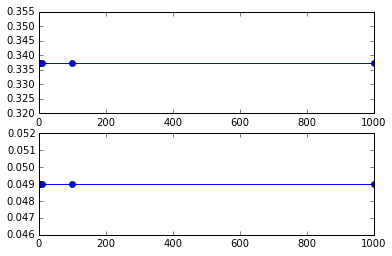

AttributeError: fmt has wrong shape.  ['%d', '%6f', '%6f', '%6f', '%6f', '%6f', '%6f', '%6f', '%6f', '%6f', '%6f', '%6f', '%6f', '%6f', '%6f', '%6f', '%6f', '%6f', '%6f', '%6f', '%6f', '%6f', '%6f', '%6f', '%6f', '%6f', '%6f', '%6f', '%6f', '%6f', '%6f', '%6f', '%6f', '%6f', '%6f', '%6f', '%6f', '%6f', '%6f', '%6f']

In [17]:
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000] }
clf = GridSearchCV(LogisticRegression(penalty='l2'), param_grid)
clf.fit(train_data, train_labels)
print clf.best_params_
#print clf.grid_scores_
res = zip(*[(f1m, f1s.std(), p['C']) 
            for p, f1m, f1s in clf.grid_scores_])

plt.subplot(2,1,1)
plt.plot(res[2],res[0],'-o')
plt.subplot(2,1,2)
plt.plot(res[2],res[1],'-o')
plt.show()

model = LogisticRegression(C=0.001)
model.fit(train_normed, train_labels)
test_predict = model.predict_proba(test_normed)
results = create_submission(test_predict)

print "Logistic Regression accuracy:", model.score(dev_normed, dev_labels)
print "Log Loss:", log_loss(dev_labels, model.predict_proba(dev_normed)) 

In [18]:
test_predict = model.predict_proba(test_normed)
create_submission(test_predict)

AttributeError: fmt has wrong shape.  ['%d', '%6f', '%6f', '%6f', '%6f', '%6f', '%6f', '%6f', '%6f', '%6f', '%6f', '%6f', '%6f', '%6f', '%6f', '%6f', '%6f', '%6f', '%6f', '%6f', '%6f', '%6f', '%6f', '%6f', '%6f', '%6f', '%6f', '%6f', '%6f', '%6f', '%6f', '%6f', '%6f', '%6f', '%6f', '%6f', '%6f', '%6f', '%6f', '%6f']

After submitting this model, we tried averaging the KNN and LR in various ways, but that did not improve the performance.

#Bernoulli Naive Bayes
##Feature Generation

BernoulliNB requires binary data, so we created dummy variables for each variable in the data set (all date and district variables). We also left all variables in the data set so that we could include and exclude features in our models easily.

In [ ]:
# Extract new features here because it's easier in Pandas than NumPy
def time_features(data):
    data['DateTime'] = pd.to_datetime(data['Dates'])
    data['Year'] = pd.DatetimeIndex(data['DateTime']).year
    data['Month'] = pd.DatetimeIndex(data['DateTime']).month
    data['Day'] = pd.DatetimeIndex(data['DateTime']).day
    data['Hour'] = pd.DatetimeIndex(data['DateTime']).hour
    data['SecondsDelta'] = (data.DateTime - pd.Timestamp('2013-01-01')) / np.timedelta64(1,'s')
    data['Weekend'] = (data.DayOfWeek == "Saturday") | (data.DayOfWeek == "Sunday")
    years = pd.get_dummies(data.Year)
    months = pd.get_dummies(data.Month)
    months.columns = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    days = pd.get_dummies(data.Day)
    daysofweek = pd.get_dummies(data.DayOfWeek)
    hours = pd.get_dummies(data.Hour)
    hours.columns = ['12AM', '1AM', '2AM', '3AM', '4AM', '5AM',
                     '6AM', '7AM', '8AM', '9AM', '10AM', '11AM',
                     '12PM', '1PM', '2PM', '3PM', '4PM', '5PM',
                     '6PM', '7PM', '8PM', '9PM', '10PM', '11PM']
    districts = pd.get_dummies(data.PdDistrict)
    new_data = pd.concat([data, years, months, days, daysofweek, hours, districts], axis=1)
    return new_data

data = time_features(data_orig)
test = time_features(test_orig)

# Separate labels
labels = data.Category

# Drop Category, Descript and Resolution columns since we cannot use them to predict
train_data = data.drop(['Category', 'Descript', 'Resolution'], axis=1)
train_names = train_data.columns.values.tolist()
test_names = test.columns.values.tolist()

print data.columns.values

In [ ]:
# Shuffle the input: create a random permutation of the integers between 0 and the number of data points and apply this
# permutation to features.
# NOTE: Each time you run this cell, you'll re-shuffle the data, resulting in a different ordering.

shuffle = np.random.permutation(np.arange(train_data.shape[0]))
train_data = train_data.reindex(shuffle)
labels = labels.reindex(shuffle)

# Remove records where Y == 90
train_data_clean = train_data[train_data.Y != 90]
labels_clean = labels[train_data.Y != 90]
num_examples = train_data_clean.shape[0]

# Split the feature and label sets into train and dev sets
mini_train_data = train_data_clean[:5000]
mini_train_labels = labels_clean[:5000]

reg_train_data = train_data_clean[5000:num_examples/2]
reg_train_labels = labels_clean[5000:num_examples/2]

dev_data = train_data_clean[num_examples/2:]
dev_labels = labels_clean[num_examples/2:]

test_data = test.copy()

print "Mini Train Data:", mini_train_data.shape
print "Mini Train Labels:", mini_train_labels.shape
print "Regular Train Data:", reg_train_data.shape
print "Regular Train Labels:", reg_train_labels.shape
print "Dev Data:", dev_data.shape
print "Dev Labels:", dev_labels.shape
print "Test Data:", test_data.shape
print "Columns in use:", train_names

In [ ]:
features_to_use = [2003L, 2004L, 2005L, 2006L, 2007L, 2008L, 2009L, 2010L, 2011L, 2012L, 2013L, 2014L, 2015L, 
                   'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 
                   1L, 2L, 3L, 4L, 5L, 6L, 7L, 8L, 9L, 10L, 11L, 12L, 13L, 14L, 15L, 
                   16L, 17L, 18L, 19L, 20L, 21L, 22L, 23L, 24L, 25L, 26L, 27L, 28L, 29L, 30L, 31L, 
                   'Friday', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 
                   '12AM', '1AM', '2AM', '3AM', '4AM', '5AM', '6AM', '7AM', '8AM', '9AM', '10AM', '11AM', 
                   '12PM', '1PM', '2PM', '3PM', '4PM', '5PM', '6PM', '7PM', '8PM', '9PM', '10PM', '11PM', 
                   'BAYVIEW', 'CENTRAL', 'INGLESIDE', 'MISSION', 'NORTHERN', 'PARK', 'RICHMOND', 
                   'SOUTHERN', 'TARAVAL', 'TENDERLOIN', 'X', 'Y'
                   ]

print "Number of features:", len(features_to_use)

The third model used Bernoulli Naive Bayes, which scored about the same as logistic regression.

In [ ]:
# Let's see what the optimal alpha is for a Bernoulli NB model

params = {'alpha': [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0]}

clf = GridSearchCV(BernoulliNB(), [params], scoring='accuracy')
clf.fit(reg_train_data[features_to_use], reg_train_labels)

print clf.best_params_
print clf.best_score_

best_alpha = clf.best_params_['alpha']

accuracies = [clf.grid_scores_[i][1] * 100 for i in range(len(clf.grid_scores_))]

plt.plot(np.log10(params['alpha']), accuracies, marker='o')
plt.xlabel("Log(Alpha)")
plt.ylabel("Accuracy")

When we throw in 99 features (basically every feature we created), the accuracy is maximized when alpha = 10. However, the practical difference in accuracy levels is very small -- we got an improvement of 0.015% when changing alpha.

In [ ]:
# How well does the Bernoulli NB model do with the selected alpha?

bnb = BernoulliNB(alpha=best_alpha)
bnb.fit(reg_train_data[features_to_use], reg_train_labels)
bnb_probs = bnb.predict_proba(test_data[features_to_use])
print "BernoulliNB accuracy:", bnb.score(dev_data[features_to_use], dev_labels)
print "Log Loss:", log_loss(dev_labels, bnb.predict_proba(dev_data[features_to_use])) 

In [ ]:
# Maybe bagging the Bernoulli NB model does us some good

bnb_bag = BaggingClassifier(BernoulliNB(alpha=best_alpha), max_features=0.8, max_samples = 0.8)
bnb_bag.fit(reg_train_data[features_to_use], reg_train_labels)
bnb_bag_probs = bnb_bag.predict_proba(test_data[features_to_use])
print "BernoulliNB with bagging accuracy:", bnb_bag.score(dev_data[features_to_use], dev_labels)
print "Log Loss:", log_loss(dev_labels, bnb_bag.predict_proba(dev_data[features_to_use])) 
print "\n"

# Perhaps doing some dimensionality reduction will help us
pca = PCA(n_components = 70)
pca_train_data = pca.fit_transform(reg_train_data[features_to_use])
pca_dev_data = pca.transform(dev_data[features_to_use])
pca_test_data = pca.transform(test_data[features_to_use])

bnb2 = BernoulliNB()
bnb2.fit(pca_train_data, reg_train_labels)
bnb2_probs = bnb2.predict_proba(pca_test_data)
print "BernoulliNB with PCA accuracy:", bnb2.score(pca_dev_data, dev_labels)
print "Log Loss:", log_loss(dev_labels, bnb2.predict_proba(pca_dev_data)) 

We tried using bagging to determine if we could get a more robust model. We also tried using PCA to reduce dimensions and using those new features in the Bernoulli NB model. However, neither of these made any significant improvements.

#Gradient Boosting

We tried Gradient Boosting, which improved our score to 2.49

In [ ]:
# Try Gradient Boosting

grad_boost = GradientBoostingClassifier()
grad_boost.fit(reg_train_data[features_to_use], reg_train_labels)
print "Logistic Regression accuracy:", grad_boost.score(dev_data[features_to_use], dev_labels)
print "Log Loss:", log_loss(dev_labels, grad_boost.predict_proba(dev_data[features_to_use])) 

Finally, we used a neural net, which got our best score of 2.45

#Appendix

In [ ]:
# Let's try a decision tree

dt = DecisionTreeClassifier()
dt.fit(reg_train_data[features_to_use], reg_train_labels)
dt_probs = dt.predict_proba(test_data[features_to_use])
print "Decision Tree accuracy:", dt.score(dev_data[features_to_use], dev_labels)
print "Log Loss:", log_loss(dev_labels, dt.predict_proba(dev_data[features_to_use])) 

In [ ]:
# Let's try a random forest

rf = RandomForestClassifier()
rf.fit(reg_train_data[features_to_use], reg_train_labels)
rf_probs = rf.predict_proba(test_data[features_to_use])
print "Random Forest accuracy:", rf.score(dev_data[features_to_use], dev_labels)
print "Log Loss:", log_loss(dev_labels, rf.predict_proba(dev_data[features_to_use])) 